In [60]:
!pip install pyspark

In [61]:
from google.colab import drive
drive.mount('/content.drive')

Mounted at /content.drive


In [62]:
import pandas as pd


read_file = pd.read_excel ("/content.drive/MyDrive/Đồ án/Big data/Online Retail.xlsx")
read_file.to_csv ("/content/OnlineRetail.csv", index = None,header=True)


df = pd.DataFrame(pd.read_csv("/content/OnlineRetail.csv"))
df.head(10)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
5,536365,22752,SET 7 BABUSHKA NESTING BOXES,2,2010-12-01 08:26:00,7.65,17850.0,United Kingdom
6,536365,21730,GLASS STAR FROSTED T-LIGHT HOLDER,6,2010-12-01 08:26:00,4.25,17850.0,United Kingdom
7,536366,22633,HAND WARMER UNION JACK,6,2010-12-01 08:28:00,1.85,17850.0,United Kingdom
8,536366,22632,HAND WARMER RED POLKA DOT,6,2010-12-01 08:28:00,1.85,17850.0,United Kingdom
9,536367,84879,ASSORTED COLOUR BIRD ORNAMENT,32,2010-12-01 08:34:00,1.69,13047.0,United Kingdom


In [63]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *

In [64]:
# Init SparkSession
spark = SparkSession.builder.appName("Pyspark Tutorial").config("spark.memory.offHeap.enabled","true").config("spark.memory.offHeap.size","10g").getOrCreate()

In [65]:
# Read data frame
df = spark.read.csv('/content/OnlineRetail.csv',header=True,escape="\"")
df.show(5)

+---------+---------+--------------------+--------+-------------------+---------+----------+--------------+
|InvoiceNo|StockCode|         Description|Quantity|        InvoiceDate|UnitPrice|CustomerID|       Country|
+---------+---------+--------------------+--------+-------------------+---------+----------+--------------+
|   536365|   85123A|WHITE HANGING HEA...|       6|2010-12-01 08:26:00|     2.55|   17850.0|United Kingdom|
|   536365|    71053| WHITE METAL LANTERN|       6|2010-12-01 08:26:00|     3.39|   17850.0|United Kingdom|
|   536365|   84406B|CREAM CUPID HEART...|       8|2010-12-01 08:26:00|     2.75|   17850.0|United Kingdom|
|   536365|   84029G|KNITTED UNION FLA...|       6|2010-12-01 08:26:00|     3.39|   17850.0|United Kingdom|
|   536365|   84029E|RED WOOLLY HOTTIE...|       6|2010-12-01 08:26:00|     3.39|   17850.0|United Kingdom|
+---------+---------+--------------------+--------+-------------------+---------+----------+--------------+
only showing top 5 rows



In [66]:
# Đếm xem có bao nhiêu dòng dữ liệu
df.count()

541909

In [67]:
# Có bao nhiêu khách hàng
df.select('CustomerID').distinct().count()

4373

Loại bỏ những đơn hàng bị hủy

In [68]:
df_filter = df.select("*").filter(~col("InvoiceNo").startswith("C"))
df_filter.count()

532621

In [69]:
df_filter.select('CustomerID').distinct().count()

4340

In [70]:
df = df_filter

In [71]:
# Cac quốc gia có số lượng khách hàng thế nào
df.groupBy('Country').agg(countDistinct('CustomerID').alias('country_count')).orderBy(desc('country_count')).show()

+---------------+-------------+
|        Country|country_count|
+---------------+-------------+
| United Kingdom|         3921|
|        Germany|           94|
|         France|           87|
|          Spain|           30|
|        Belgium|           25|
|    Switzerland|           21|
|       Portugal|           19|
|          Italy|           14|
|        Finland|           12|
|        Austria|           11|
|         Norway|           10|
|        Denmark|            9|
|Channel Islands|            9|
|      Australia|            9|
|    Netherlands|            9|
|         Sweden|            8|
|         Cyprus|            8|
|          Japan|            8|
|         Poland|            6|
|         Greece|            4|
+---------------+-------------+
only showing top 20 rows



In [72]:
# Định dạng lại trường dữ liệu ngày tháng thành timestamp để có thể sort, tìm min hoặc max
spark.sql("set spark.sql.legacy.timeParserPolicy=LEGACY")
df = df.withColumn('date',to_timestamp("InvoiceDate", 'yy-MM-dd HH:mm:ss'))
# Ngày có đơn hàng gần đây nhất
df.select(max("date")).show()

+-------------------+
|          max(date)|
+-------------------+
|2011-12-09 12:50:00|
+-------------------+



In [73]:
# Ngày đầu tiên có đơn hàng
df.select(min("date")).show()

+-------------------+
|          min(date)|
+-------------------+
|2010-12-01 08:26:00|
+-------------------+



# **Recency**

In [74]:
df = df.withColumn("from_date", lit("2010-12-01 08:26:00"))
df = df.withColumn('from_date',to_timestamp("from_date", 'yy-MM-dd HH:mm'))

df2=df.withColumn('from_date',to_timestamp(col('from_date'))).withColumn('recency',col("date").cast("long") - col('from_date').cast("long"))

In [75]:
df2 = df2.join(df2.groupBy('CustomerID').agg(max('recency').alias('recency')),on='recency',how='leftsemi')

In [76]:
df2.show()

+-------+---------+---------+--------------------+--------+-------------------+---------+----------+--------------+-------------------+-------------------+
|recency|InvoiceNo|StockCode|         Description|Quantity|        InvoiceDate|UnitPrice|CustomerID|       Country|               date|          from_date|
+-------+---------+---------+--------------------+--------+-------------------+---------+----------+--------------+-------------------+-------------------+
|   5220|   536384|    82484|WOOD BLACK BOARD ...|       3|2010-12-01 09:53:00|     6.45|   18074.0|United Kingdom|2010-12-01 09:53:00|2010-12-01 08:26:00|
|   5220|   536384|    84755|COLOUR GLASS T-LI...|      48|2010-12-01 09:53:00|     0.65|   18074.0|United Kingdom|2010-12-01 09:53:00|2010-12-01 08:26:00|
|   5220|   536384|    22464|HANGING METAL HEA...|      12|2010-12-01 09:53:00|     1.65|   18074.0|United Kingdom|2010-12-01 09:53:00|2010-12-01 08:26:00|
|   5220|   536384|    21324|HANGING MEDINA LA...|       6|2010-

# **Frequency**

In [77]:
df_freq = df2.groupBy('CustomerID').agg(count('InvoiceNo').alias('frequency'))

In [78]:
df_freq.show()

+----------+---------+
|CustomerID|frequency|
+----------+---------+
|   17786.0|       72|
|   16917.0|        9|
|   15891.0|       62|
|   17955.0|        1|
|   14542.0|        5|
|   12891.0|        1|
|   16553.0|        1|
|   14532.0|       20|
|   17536.0|        3|
|   14722.0|       29|
|   13827.0|       65|
|   17353.0|        4|
|   15070.0|        1|
|   16351.0|        8|
|   18085.0|       20|
|   12350.0|       17|
|   14727.0|       10|
|   16838.0|       11|
|   13533.0|       33|
|   15016.0|       20|
+----------+---------+
only showing top 20 rows



In [79]:
# join data
df3 = df2.join(df_freq,on='CustomerID',how='inner')

In [80]:
df3.show()

+----------+-------+---------+---------+--------------------+--------+-------------------+---------+--------------+-------------------+-------------------+---------+
|CustomerID|recency|InvoiceNo|StockCode|         Description|Quantity|        InvoiceDate|UnitPrice|       Country|               date|          from_date|frequency|
+----------+-------+---------+---------+--------------------+--------+-------------------+---------+--------------+-------------------+-------------------+---------+
|   18074.0|   5220|   536384|    82484|WOOD BLACK BOARD ...|       3|2010-12-01 09:53:00|     6.45|United Kingdom|2010-12-01 09:53:00|2010-12-01 08:26:00|       13|
|   18074.0|   5220|   536384|    84755|COLOUR GLASS T-LI...|      48|2010-12-01 09:53:00|     0.65|United Kingdom|2010-12-01 09:53:00|2010-12-01 08:26:00|       13|
|   18074.0|   5220|   536384|    22464|HANGING METAL HEA...|      12|2010-12-01 09:53:00|     1.65|United Kingdom|2010-12-01 09:53:00|2010-12-01 08:26:00|       13|
|   

# **Monetary**

In [81]:
m_val = df3.withColumn('TotalAmount',col("Quantity") * col("UnitPrice"))

In [82]:
m_val = m_val.groupBy('CustomerID').agg(sum('TotalAmount').alias('monetary_value'))

In [83]:
m_val.show()

+----------+------------------+
|CustomerID|    monetary_value|
+----------+------------------+
|   17786.0|            278.74|
|   16917.0| 391.5200000000001|
|   15891.0|            524.52|
|   17955.0|             163.2|
|   14542.0|103.25000000000001|
|   12891.0|              85.0|
|   16553.0|             204.0|
|   14532.0|            140.55|
|   17536.0|              76.5|
|   14722.0|187.91999999999996|
|   13827.0|            299.31|
|   17353.0|             870.0|
|   15070.0|             106.2|
|   16351.0|             153.9|
|   18085.0|386.04999999999995|
|   12350.0|334.40000000000003|
|   14727.0|            268.58|
|   16838.0|196.73000000000002|
|   13533.0|124.14999999999999|
|   15016.0|            170.04|
+----------+------------------+
only showing top 20 rows



In [84]:
m_val.select('monetary_value').show()

+------------------+
|    monetary_value|
+------------------+
|            278.74|
| 391.5200000000001|
|            524.52|
|             163.2|
|103.25000000000001|
|              85.0|
|             204.0|
|            140.55|
|              76.5|
|187.91999999999996|
|            299.31|
|             870.0|
|             106.2|
|             153.9|
|386.04999999999995|
|334.40000000000003|
|            268.58|
|196.73000000000002|
|124.14999999999999|
|            170.04|
+------------------+
only showing top 20 rows



In [85]:
# join
final_df = m_val.join(df3,on='CustomerID',how='inner')

In [86]:
final_df.show()

+----------+--------------+-------+---------+---------+--------------------+--------+-------------------+---------+--------------+-------------------+-------------------+---------+
|CustomerID|monetary_value|recency|InvoiceNo|StockCode|         Description|Quantity|        InvoiceDate|UnitPrice|       Country|               date|          from_date|frequency|
+----------+--------------+-------+---------+---------+--------------------+--------+-------------------+---------+--------------+-------------------+-------------------+---------+
|   17786.0|        278.74|4860540|   542239|    21166|COOK WITH WINE ME...|       3|2011-01-26 14:35:00|     1.95|United Kingdom|2011-01-26 14:35:00|2010-12-01 08:26:00|       72|
|   17786.0|        278.74|4860540|   542239|    21181|PLEASE ONE PERSON...|       2|2011-01-26 14:35:00|      2.1|United Kingdom|2011-01-26 14:35:00|2010-12-01 08:26:00|       72|
|   17786.0|        278.74|4860540|   542239|    85150|LADIES & GENTLEME...|       1|2011-01-26

# **Kiểm tra môn hình dữ liệu cho học máy**

In [87]:
final_df = final_df.select(['recency','frequency','monetary_value','CustomerID']).distinct()
final_df.show()

+--------+---------+------------------+----------+
| recency|frequency|    monetary_value|CustomerID|
+--------+---------+------------------+----------+
| 4860540|       72|            278.74|   17786.0|
| 8393340|        9| 391.5200000000001|   16917.0|
|12715740|       62|            524.52|   15891.0|
|15132840|        1|             163.2|   17955.0|
|16242780|        5|103.25000000000001|   14542.0|
|16257900|        1|              85.0|   12891.0|
|18170160|        1|             204.0|   16553.0|
|11853540|       20|            140.55|   14532.0|
|16952220|        3|              76.5|   17536.0|
|19549920|       29|187.91999999999996|   14722.0|
|20747940|       65|            299.31|   13827.0|
|21113580|        4|             870.0|   17353.0|
|   97020|        1|             106.2|   15070.0|
| 3549600|        8|             153.9|   16351.0|
| 3739860|       20|386.04999999999995|   18085.0|
| 5470500|       17|334.40000000000003|   12350.0|
| 8576340|       10|           

# **Chuẩn hóa dữ liệu**

In [88]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StandardScaler

assemble=VectorAssembler(inputCols=[
    'recency','frequency','monetary_value'
], outputCol='features')

assembled_data=assemble.transform(final_df)

scale=StandardScaler(inputCol='features',outputCol='standardized')
data_scale=scale.fit(assembled_data)
data_scale_output=data_scale.transform(assembled_data)

In [89]:
data_scale_output.select('standardized').show(2,truncate=False)

+-----------------------------------------------------------+
|standardized                                               |
+-----------------------------------------------------------+
|[0.5600258964872268,1.8173891485441465,0.09947228534979762]|
|[0.967071098689055,0.2271736435680183,0.1397194129301599]  |
+-----------------------------------------------------------+
only showing top 2 rows



# **Xây dựng mô hình học máy K-means**

# **Tìm số cụm K**

In [90]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
import numpy as np
from tqdm import tqdm


cost = np.zeros(10)

evaluator = ClusteringEvaluator(predictionCol='prediction', featuresCol='standardized',metricName='silhouette', distanceMeasure='squaredEuclidean')

for i in tqdm(range(2,10)):
    KMeans_algo=KMeans(featuresCol='standardized', k=i)
    KMeans_fit=KMeans_algo.fit(data_scale_output)
    output=KMeans_fit.transform(data_scale_output)
    cost[i] = KMeans_fit.summary.trainingCost

100%|██████████| 8/8 [08:21<00:00, 62.66s/it]


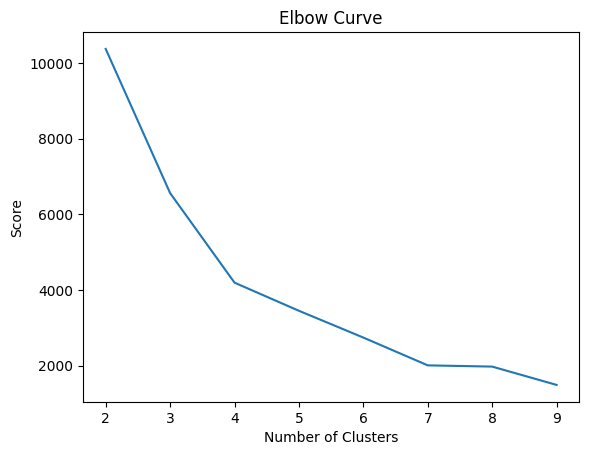

In [91]:
import pandas as pd
import pylab as pl
df_cost = pd.DataFrame(cost[2:])
df_cost.columns = ["cost"]
new_col = range(2,10)
df_cost.insert(0, 'cluster', new_col)
pl.plot(df_cost.cluster, df_cost.cost)
pl.xlabel('Number of Clusters')
pl.ylabel('Score')
pl.title('Elbow Curve')
pl.show()

# **Training K-means với k=4**

In [92]:
kmeans_algo=KMeans(featuresCol='standardized', k=4)
kmeans_fit=kmeans_algo.fit(data_scale_output)

# **Tiến hành dự đoán cụm**

In [93]:
preds=kmeans_fit.transform(data_scale_output)
preds.show(5)

+--------+---------+------------------+----------+--------------------+--------------------+----------+
| recency|frequency|    monetary_value|CustomerID|            features|        standardized|prediction|
+--------+---------+------------------+----------+--------------------+--------------------+----------+
| 4860540|       72|            278.74|   17786.0|[4860540.0,72.0,2...|[0.56002589648722...|         1|
| 8393340|        9| 391.5200000000001|   16917.0|[8393340.0,9.0,39...|[0.96707109868905...|         1|
|12715740|       62|            524.52|   15891.0|[1.271574E7,62.0,...|[1.46509311578517...|         1|
|15132840|        1|             163.2|   17955.0|[1.513284E7,1.0,1...|[1.74358863159191...|         1|
|16242780|        5|103.25000000000001|   14542.0|[1.624278E7,5.0,1...|[1.87147465733124...|         1|
+--------+---------+------------------+----------+--------------------+--------------------+----------+
only showing top 5 rows



# **Trực quan hóa kết quả phân cụm**

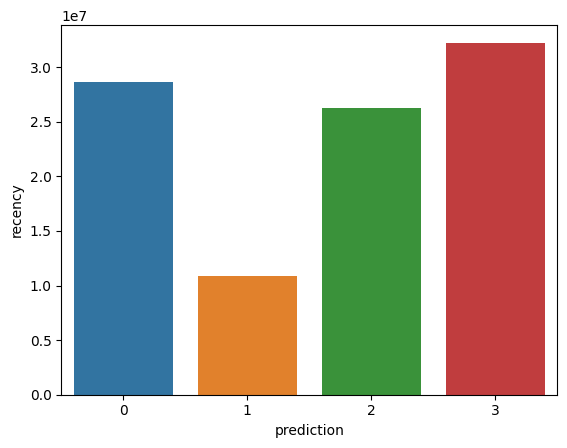

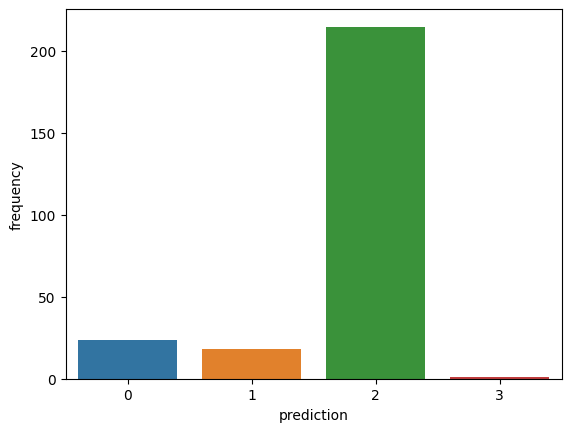

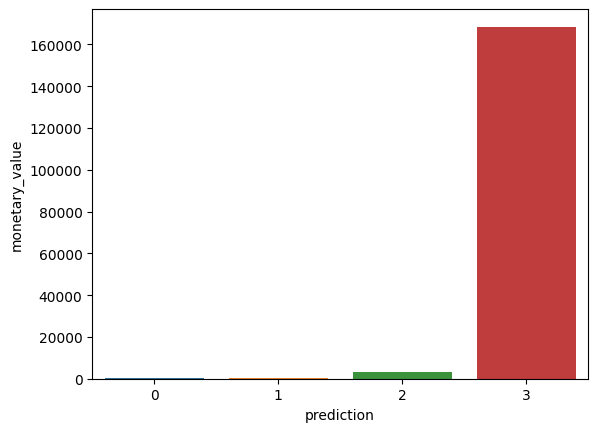

In [94]:
import matplotlib.pyplot as plt
import seaborn as sns

df_viz = preds.select('recency','frequency','monetary_value','prediction')
df_viz = df_viz.toPandas()
avg_df = df_viz.groupby(['prediction'], as_index=False).mean()

list_value = ['recency','frequency','monetary_value']

for i in list_value:
    sns.barplot(x='prediction',y=str(i),data=avg_df)
    plt.show()